## 0. Install and import packages

### How to install "openslide" for python, see below

In [4]:
!apt-get install --yes openslide-tools

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 22 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 2s (54.4 kB/s)        
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline
Selecting previously unselected package libope

In [5]:
!pip install openslide-python

     |████████████████████████████████| 316 kB 1.3 MB/s eta 0:00:01
  Created wheel for openslide-python: filename=openslide_python-1.1.2-cp36-cp36m-linux_x86_64.whl size=26750 sha256=4f2bb2a3a88d19eb148fc6cef7a1077c085c34edd0aa629e621e23c63c3180e0
  Stored in directory: /root/.cache/pip/wheels/ac/d1/f8/f226d1f46dfe6c8fc332167949f318bd2fcb4e228aa4731259
Successfully built openslide-python
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


### Import pakages

In [2]:
import openslide
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import cv2
import os
import random
import shutil
import scipy.misc
import scipy.ndimage
from skimage import io
from skimage import morphology
from skimage import measure

from lxml import etree
import math
import glob
from PIL import Image
import imutils

# copy & paste directory into path_common 
path_common = '../'

## 1. Sample .svs, .xml

### Show .svs

In [3]:
fname_WSI = 'S 050026746_8_PAS.svs'
path_WSI = os.path.join(path_common, 'data/', fname_WSI)
path_out_tissue_mask = os.path.join(path_common , 'mask/')
if not os.path.exists(path_out_tissue_mask):
    os.makedirs(path_out_tissue_mask)

In [4]:
# comparing WSI dimensions by resolution level

org_slide = openslide.OpenSlide(path_WSI) # original tif load
 
dims_level_0 = org_slide.level_dimensions[0]
print('level 0 dimensions (x,y):        ', dims_level_0)
print('*'*50)
dims_level_1 = org_slide.level_dimensions[1]
print('level 2 dimensions (x,y):        ', dims_level_1)
print('level 0 dimensions divided by 4 : ', int(dims_level_0[0]/4), int(dims_level_0[1]/4))
print('*'*50)

dims_level_2 = org_slide.level_dimensions[2]
print('level 4 dimensions (x,y):        ', dims_level_2)
print('level 0 dimensions divided by 16 : ', int(dims_level_0[0]/16), int(dims_level_0[1]/16))
print('*'*50)

dims_level_3 = org_slide.level_dimensions[3]
print('level 8 dimensions (x,y):        ', dims_level_3)
print('level 0 dimensions divided by 64 : ', int(dims_level_0[0]/64), int(dims_level_0[1]/64))
print('*'*50)

level 0 dimensions (x,y):         (151391, 47659)
**************************************************
level 2 dimensions (x,y):         (37847, 11914)
level 0 dimensions divided by 4 :  37847 11914
**************************************************
level 4 dimensions (x,y):         (9461, 2978)
level 0 dimensions divided by 16 :  9461 2978
**************************************************
level 8 dimensions (x,y):         (2365, 744)
level 0 dimensions divided by 64 :  2365 744
**************************************************


(37847, 11914)
37847 11914


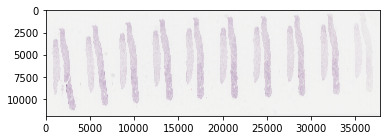

In [5]:
# visualize WSI at level 2

LEVEL_OPENSLIDE = 1   # set resolution level (level 2 =  1/4 resolution)
dims_level_2 = org_slide.level_dimensions[LEVEL_OPENSLIDE]
print(dims_level_2)

WSI_array = np.array(org_slide.read_region([0, 0],LEVEL_OPENSLIDE, [dims_level_2[0], dims_level_2[1]]))[:,:,0:3]
print(WSI_array.shape[1],WSI_array.shape[0])

plt.imshow(WSI_array)
plt.show()

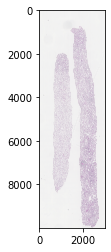

In [6]:
plt.imshow(WSI_array[:10000, 19000:22000])
plt.show()

### Make mask from .xml

In [7]:
fname_XML = 'S 050026746_8_PAS.xml'
path_XML = os.path.join(path_common, 'data/', 'S 050026746_8_PAS.xml')

In [8]:
def make_mask(path_WSI, path_XML, id_list):
    tree = etree.parse(path_XML)
    root = tree.getroot()

    cnt = []

    for root_ in (root.iter('Annotation')):
    # class level
    #     print(root_.attrib)        
        if root_.attrib['Id'] in id_list:
            for anno_ in (root_.iter('Region')):
                # single tissue level
                rect_ = []

                for child in anno_.iter("Vertex"):
                    # contour points level
                    cooldinates = child.attrib

                    x_ = int(round(float(cooldinates.get('X')))) // 4
                    y_ = int(round(float(cooldinates.get('Y')))) // 4
                    rect_.append((x_, y_))

                cnt.append(rect_)

    image = openslide.OpenSlide(path_WSI)
    w,h = image.level_dimensions[1]

    mask = np.zeros((h,w),dtype=np.uint8)

    for i in range(len(cnt)):
        mask_pts = np.array(cnt[i]).reshape((-1, 1, 2)).astype(np.int32)
        cv2.fillPoly(mask, [mask_pts], [255])
    
    return mask, cnt

In [9]:
id_list = ['1', '2', '3', '4', '5', '6']
mask_, cnt_ = make_mask(path_WSI, path_XML, id_list)
print('Num of masks: ', len(cnt_))

Num of masks:  8


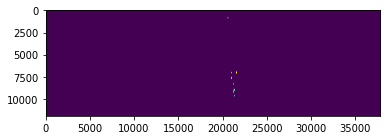

In [10]:
plt.imshow(mask_)
plt.show()

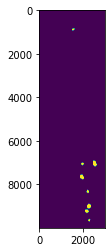

In [11]:
plt.imshow(mask_[:10000, 19000:22000])
plt.show()

### Layers

In [12]:
masks = []
for i in id_list:
    mask, cnt = make_mask(path_WSI, path_XML, i)
    print(f'Num of masks{i}: ', len(cnt))
    masks.append(mask)

Num of masks1:  4
Num of masks2:  2
Num of masks3:  0
Num of masks4:  2
Num of masks5:  0
Num of masks6:  0


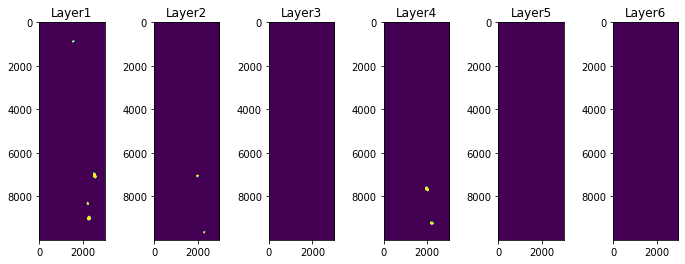

In [13]:
plt.figure(figsize=(12, 4))

for i in range(6):
    plt.subplot(161+i)
    plt.title(f'Layer{1+i}')
    plt.imshow(masks[i][:10000, 19000:22000])
    
plt.show()

## 2. Extract labels

In [14]:
import pandas as pd

In [15]:
gloms = {}
for i in id_list:
    mask, cnt = make_mask(path_WSI, path_XML, i)
    print(f'Num of masks{i}: ', len(cnt))
    gloms[i]=cnt

Num of masks1:  4
Num of masks2:  2
Num of masks3:  0
Num of masks4:  2
Num of masks5:  0
Num of masks6:  0


In [40]:
df = pd.DataFrame()
for i in id_list:
    label_dict = {}
    label_dict["filename"] = path_WSI.split('/')[-1]
    mask, cnt = make_mask(path_WSI, path_XML, i)
    print(f'Num of masks{i}: ', len(cnt))
    label_dict["layer"] = i
    label_dict["cnt"] = cnt
    label_df = pd.DataFrame(label_dict)
    df = pd.concat([df, label_df], axis=0)
df = df.reset_index(drop=True)

Num of masks1:  4
Num of masks2:  2
Num of masks3:  0
Num of masks4:  2
Num of masks5:  0
Num of masks6:  0


In [41]:
df

,filename,layer,cnt
0,S 050026746_8_PAS.svs,1,"[(20571, 923), (20567, 925), (20562, 927), (20..."
1,S 050026746_8_PAS.svs,1,"[(21575, 7165), (21582, 7162), (21589, 7159), ..."
2,S 050026746_8_PAS.svs,1,"[(21236, 8250), (21232, 8249), (21228, 8248), ..."
3,S 050026746_8_PAS.svs,1,"[(21321, 9090), (21323, 9088), (21326, 9084), ..."
4,S 050026746_8_PAS.svs,2,"[(21018, 7092), (21021, 7089), (21023, 7086), ..."
5,S 050026746_8_PAS.svs,2,"[(21329, 9588), (21325, 9588), (21321, 9587), ..."
6,S 050026746_8_PAS.svs,4,"[(21035, 7696), (21036, 7701), (21036, 7707), ..."
7,S 050026746_8_PAS.svs,4,"[(21259, 9233), (21259, 9235), (21259, 9238), ..."


In [42]:
pts_dict = {"rmost": [], "bmost": [], "lmost": [], "tmost": []}
for cnt_pt in df.cnt:
    rmost, bmost = np.array(cnt_pt).max(axis=0)
    lmost, tmost = np.array(cnt_pt).min(axis=0)
    pts_dict["rmost"].append(rmost)
    pts_dict["bmost"].append(bmost)
    pts_dict["lmost"].append(lmost)
    pts_dict["tmost"].append(tmost)
pts_df = pd.DataFrame(pts_dict)
df = pd.concat([df, pts_df], axis=1)

In [43]:
df

,filename,layer,cnt,rmost,bmost,lmost,tmost
0,S 050026746_8_PAS.svs,1,"[(20571, 923), (20567, 925), (20562, 927), (20...",20621,937,20487,834
1,S 050026746_8_PAS.svs,1,"[(21575, 7165), (21582, 7162), (21589, 7159), ...",21619,7176,21451,6894
2,S 050026746_8_PAS.svs,1,"[(21236, 8250), (21232, 8249), (21228, 8248), ...",21275,8390,21158,8246
3,S 050026746_8_PAS.svs,1,"[(21321, 9090), (21323, 9088), (21326, 9084), ...",21370,9104,21174,8889
4,S 050026746_8_PAS.svs,2,"[(21018, 7092), (21021, 7089), (21023, 7086), ...",21028,7116,20922,6993
5,S 050026746_8_PAS.svs,2,"[(21329, 9588), (21325, 9588), (21321, 9587), ...",21339,9693,21240,9585
6,S 050026746_8_PAS.svs,4,"[(21035, 7696), (21036, 7701), (21036, 7707), ...",21037,7763,20855,7539
7,S 050026746_8_PAS.svs,4,"[(21259, 9233), (21259, 9235), (21259, 9238), ...",21262,9306,21091,9141


In [44]:
df.to_csv(os.path.join(path_out_tissue_mask, "test.csv"), index=False)

In [18]:
max_lst = []
min_lst = []
for pts in df.cnt:
    max_lst.append(np.array(pts).max(axis=0))
    min_lst.append(np.array(pts).min(axis=0))
rmost, bmost = np.array(max_lst).max(axis=0)
lmost, tmost = np.array(min_lst).min(axis=0)

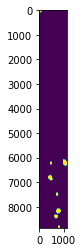

In [19]:
plt.imshow(mask_[tmost:bmost, lmost:rmost])
plt.show()

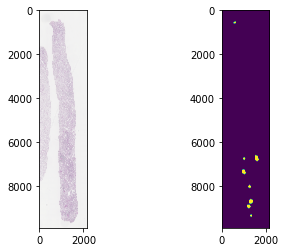

In [23]:
padding = 512
crop_mask = mask_[tmost-padding:bmost+padding, lmost-padding:rmost+padding]
crop_img = WSI_array[tmost-padding:bmost+padding, lmost-padding:rmost+padding]
plt.subplot(121)
plt.imshow(crop_img)
plt.subplot(122)
plt.imshow(crop_mask)
plt.show()

## 3. Save as .tiff

In [24]:
WSI_im = Image.fromarray(crop_img)
mask_im = Image.fromarray(crop_mask)

In [25]:
WSI_im.save(os.path.join(path_common, 'data/', f"{fname_WSI[:-4]}.tiff"))
mask_im.save(os.path.join(path_common, 'mask/', f"{fname_WSI[:-4]}_mask.tiff"))